In [1]:
import numpy as np
import torch

## Wyzwanie
Perceptron dla obecnych sieci neuronowych jest jak Australopitek dla Homo sapiens - możemy się śmiać, że sieć kiedyś była taka prymitywna, ale bez zrozumienia niej - nie zrozumiemy całego skomplikowania nowoczesnych architektur. Twoim zadaniem będzie implementacja perceptronu, a także jego nauka od zera. Wyniki zweryfikujesz implementując na końcu taką samą sieć w [Pytorchu](https://docs.pytorch.org/docs/stable/index.html).

## Jak zrobić zadanie
0. Dane są te same co w poprzednim zadaniu - [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
1. Wykorzystaj wiedzę z poprzedniego notebooka (jak i kod, jeśli się da) do przygotowania danych. Pamiętaj o podziale na zbiory train, val i test. Przeskaluj dane używając StandardScaler lub innych, oczywiście unikając wycieku danych.
2. Możecie ograniczyć się do dwóch cech wejściowych - wybranych wedle uznania - do celów zadania (np. dwie cechy łatwiej jest zwizualizować)
3. Niżej są podane instrukcje (symbol ⚡ oznacza, że coś trzeba zaimplementować) - najlepiej rób je sekwencyjnie.

przydatne materiały:
* [deep_learning_60min_blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html),
* [zrozumienie under/overfitting](https://mlu-explain.github.io/bias-variance/),
* [SUPER tutorial(e)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html),
* [Mathematics of neural networks in machine learning](https://en.wikipedia.org/wiki/Mathematics_of_neural_networks_in_machine_learning),
* [Pozycja 53 -> rozdziały 2 (fenomenalny),11](https://docs.google.com/spreadsheets/d/1UnjOh5TYgNiFBw9jsM6mJrp68uEdzeW3iIi6Ew0xfgQ/edit?gid=0#gid=0),
* [Optymizatory & uczenie paczkami](https://arxiv.org/pdf/1609.04747)


### Problemy w uczeniu maszynowym

Przypomnijmy sobie jeszcze czym się różni zadanie **klasyfikacji** od **regresji**. Jak już zapewne wiesz, nasze dane można podzielić na zbiór cech (X) oraz na zbiór zmiennych docelowych (y). Ten drugi może kodować informacje o tym, jaka jest klasa przynależności (np. *chory ∈ {true, false}*, *kolor ∈ {zielony, niebieski, czerwony}*), lub jaka jest wartość pewnej cechy (np. *temperatura ∈ ℜ*, *punkty z egzaminu* ∈ 𝒵). W zadaniu klasyfikacji mamy do czynienia z kategoriami, które są dyskretne, a w zadaniu regresji zmienne docelowe są zwykle ciągłe. Dlaczego to istotne? W trakcie pracy nad notebookiem pewnie zdasz sobie sprawę, że nie można do problemu klasyfikacji użyć straty najmniejszych kwadratów - co byłoby odpowiednie w problemie regresji.

## 1. Perceptron*
Wejdziemy w trochę matematyki (serio, matma jest niezbędna jeśli chcesz być Pro AI engineer'em). Najprostszy perceptron opisany jest wzorem

$$A = σ(𝑤^TX + b) = σ(Z) = (a_1, ..., a_{m-1})$$
gdzie


*   σ to funkcja aktywacji
*   $X$ to macierz cech, wymiaru $k \times m$ ($=$ liczba cech $\times$ liczba próbek)
*   𝑤 to macierz wag z $k$ wartościami (wyuczalne parametry)
*   b to skalar, zwany *biasem* (wyuczalny parametr)
*   $A$ to wyjściowy wektor o długości $m$

Popularne funkcje aktywacji:
- Relu: $f(Z) = max(Z, 0)$
- Sigmoid: $f(Z) = \frac{1}{1 + e^{-Z}}$

Jednak w tym zadaniu poprawna będzie tylko jedna - musisz sam(a) wybrać która to będzie i dlaczego. (Hint: zastanów się, *co oznacza wyjście sieci*, i dlaczego ta "niepoprawna" funkcja aktywacji będzie psuła sieć)

*W rzeczywistości nie będzie to [stricte perceptron](https://pl.wikipedia.org/wiki/Perceptron), ponieważ nie będziemy implementować skokowej funkcji straty.

### ⚡ Zaimplementuj tutaj perceptron

In [3]:
class Perceptron:

  def __init__(self, n_features):
    self.n_features = n_features
    self.weights = [0 for x in range(n_features)]
    self.bias = 0
    
  def forward(self, X: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    weighted_sum = self.bias

    for i, _ in enumerate(self.weights):
      weighted_sum += X[i] *self.weights[i]

    if weighted_sum > 0:
      prediction = 1
    else:
      prediction = 0

    return prediction

### Przejście w przód i w tył

Następnym zadaniem jest wyuczenie naszych macierzy. Prawdopodobnie twoje wartości są losowe (mam nadzieję, że macierz nie jest wypełniona zerami), przez co i sieć daje losowe wyniki. To, co możemy wydzielić jako atomową operację w procesie uczenia sieci składa się z kroków:
1. Forward propagation (przejście w przód) - wymnożenie wejściowych cech przez wagi sieci
2. Loss (obliczanie straty) - obliczamy jaki jest błąd popełniany przez sieć
3. Backward propagation (przejście w tył) - propagacja gradientu i **aktualizacja** wag sieci

Proces uczenia zachodzi w N epokach.

Pytanie filozoficzne: czy strata może być równa zero? czy możemy wyczyć idealną sieć? Jak sądzisz, w jakich warunkach tak może być? (warto na takie przemyślenie poświęcić >=30 sekund).

Matematycznie ma to taką postać:
* Fp: $A = σ(𝑤^TX + b) = σ(Z)$ (to było już)
* Loss: L = $\frac{1}{M} g(A, Gt)$, gdzie $Gt$ to prawdziwe, poprawne wartości, a $g$ to odpowiednia dla problemu funkcja straty. Dzielimy przez liczbę próbek, bo chcemy uzyskać średnią wartość błędu,
* Bp: niestety nie zachodzi w jednym kroku. Rozpiszmy to

$$L = \frac{1}{M} g(A, Gt)$$  -> mamy nasz wyliczony loss (musimy mieć wartość skalarną, dlatego uśredniamy startę)
$$\frac{∂L}{∂𝑤} = ? $$ -> to chcemy wyliczyć (zaraz, zaraz powiemy po co)
$$ \frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$$ -> to wynika z [twierdzenia łańcuchowego](https://en.wikipedia.org/wiki/Chain_rule)

Jaki mamy deal z tego? Otóż będziemy obliczać pochodne zmiany funkcji starty względem parametrów sieci tak, by je dostosowywać w kierunku zmniejszenia się tej straty (spadek wzdłuż gradientu [link text](https://en.wikipedia.org/wiki/Gradient_descent)). Aktualizacja wag sieci, w epoce n, ma postać:

$$𝑤^{n + 1} = 𝑤^{n} - \alpha \frac{∂L}{∂𝑤}$$

gdzie $\alpha$ jest hiperparameterem (czyli taką wartością, która jest ustalana z góry, przed uruchomieniem treningu), zwykle o wartościach $0.01$, czy $0.001$.
 Decyduje ona o szybkości treningu.

 Twoim zadaniem jest teraz ⚡ implementacja klasy do trenowania, dla której docelowo chcemy tylko wywołać funkcję *train*, a w środku ma zachodzić cała magia. Funkcja *predict* ma służyć do predykcji kategorii dla próbek testowych.

In [ ]:
class Trainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int = 50):
    self.perceptron = perceptron
    self.n_epochs = n_epochs

  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    return None

  def backward(self, X: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    return None

  def update_weights(self, X, y): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    pred = self.perceptron.forward(X)
    error = y - pred

    self.perceptron.bias += error
    for i, _ in enumerate(self.perceptron.weights):
      self.perceptron.weights[i] += error * X[i]
    
    return error

  def train(self, X: np.ndarray, y: np.ndarray): # wykonuje trenowanie w N epokach
    
    for _ in range(self.n_epochs):
      error_count = 0

      for x_i,y_i in zip(X,y):
        error = self.update_weights(x_i,y_i)
        error_count += abs(error)

    return self

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    return None

## HINTS
Hint1: na kartce rozpisz sobie krok po kroku przejście w przód. Najlepiej użyj tej samej konwencji nazewniczej zmiennych, lub zdefiniuj zmienne pomocniczne. Rozwiń jaki będzie konkretny wzór na pochodne: $\frac{∂L}{∂A}$, $\frac{∂A}{∂z}$ i  $\frac{∂z}{∂w}$. Jak już przez to przebrniesz, to przepisanie tego do Pythona powinno być bezbolesne i skuteczne.

Hint2: Funkcje straty, które powinieneś/powinnaś rozważać to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) lub [BCE](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/). Jeśli rozpisanie gradientu jest dla ciebie nie do przejścia, to posłuż się "gotowcem", ale nadal spróbuj samodzielnie przepisać na kod.

Hint3: do mnożenia macierzy w numpy używamy ```np.dot``` lub ```@```.

Hint4: początkowe wartości macierzy $𝑤$ mogą być zaincjalizowane losowymi wartościami z niewielkiego zakresu (np. $[-0.01, 0.01]$)

Hint5: wartości wejściowe powinny być ustandaryzowane (dla poprawy jakości spadku wzdłuż gradientu)

### Uczenie paczkami
Być może już zauważyłeś/łaś, że wymnażanie wielkiej macierzy $X$ w pojedynczym kroku jest problematyczne - jeśli nie w tym eksperymencie, to w następnym. Istnieją różne strategie do aktualizacji parametrów:
* batch gradient descent - aktualizacja parametrów odbywa się po przejściu wszystkich próbek przez sieć, a gradient jest uśredniany (to, co pewnie masz teraz)
* stochastic gradient descent - aktualizacja parametrów następuje po każdej pojedynczej próbce (podejście na drugim końcu spektrum)
* mini-batch stochastic gradient descent - podział wszystkich próbek na paczki o wielkości $M$, i aktualizacja gradientu po każdej paczce (podejście "po środku" dwóch poprzednich)

Zastanów się, które podejście jest odpowiednie i w funkcji *train* ⚡ doimplementuj odpowiedni podział (lub nie?) macierzy danych $X$.

Nic nie stoi na przeszkodzie, by udokumentować zachowanie sieci dla każdej strategii (możesz to zawrzeć w dalszej sekcji eksperymentów).


### Śledzenie przebiegu uczenia

W praktyce, sam spadek wzdłuż gradientu nie gwarantuje, że dostaniemy optymalne wagi sieci. W celu weryfikacji, czy nie doszło do **przeuczenia**, twoim ⚡ kolejnym krokiem będzie dodanie do klasy *Trainer* funkcji, które zapiszą, na końcu każdej epoki

 (a) istotne metryki w kontekście zadania,

(b) wartość straty

zarówno dla zbioru treningowego, jak i walidacyjnego - najlepiej w postaci wykresu. Na ich podstawie zdiagnozuj, czy model podlega **niedouczeniu / underfitting**, **przeuczeniu / overfitting**, a może jest względnie "dobry".  

### ⭐ Ekstra zadanie - optymizator
Spadek wzdłuż gradientu zawsze bierze pod uwagę tylko aktualne wartości gradientów, przez co może być podatny na gwałtowne zmiany. W celu wydajniejszego trenowania stosuje się [optymizatory](https://arxiv.org/pdf/1609.04747) typu *Momentum* czy *Adagrad* (choć w praktyce zwykle *Adam*). Zaimplementuj wybrany optimzator i porównaj, jak uczy się sieć z i bez, oraz jak zmieniają się wartości wag (np. możesz logować bezwzględną, uśrednioną wartość zmian wag).

### ⚡ Eksperymenty
Zbadaj skuteczność sieci oraz oceń, czy dobrze się generalizuje na podstawie krzywych uczenia. Dokładniej, zbadaj co najmniej **3 wartości współczynnika uczenia** i **3 wartości liczby epok**. Zapisz swoje obserwacje. Nie przejmuj się, jeśli po nieudanych próbach twoja sieć nie chce się uczyć - jeśli czujesz, że wiesz w czym leży błąd, to zapisz te obserwacje.

## 2. Implementacja sieci w pytorchu
Następnie ⚡ zaimplementujesz perceptron korzystając z biblioteki pytorch w celu weryfikacji wyników.

### Tensory
Są to struktury danych zbliżone do macierzy **np.array**, tyle, że mogą być przenoszone na karty graficzne, które są niezbędne do wyuczenia głębokich sieci. W następującej części zadania będziesz musiał(a) opanować pracę z tensorami i ich zamianę z i do tablicy NumPy.

In [ ]:
data_list = [[2, 5], [3, 6],[4, 7]]
numpy_array = np.array(data_list) # tablica numpy utworzona z listy
data_tensor = torch.from_numpy(numpy_array) # tensor utworzony z tablicy numpy
print(data_tensor.shape) # kształt tensora
data_tensor

torch.Size([3, 2])


tensor([[2, 5],
        [3, 6],
        [4, 7]])

### Perceptron w torchu
Z wykorzystaniem biblioteki [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) ⚡ zaimplementuj jednowarstwową sieć neuronową wraz z jej trenowaniem, z która porównasz swoją sieć zbudowaną w numpy. Przydatny może być tutorial [pytorch-nn](https://docs.pytorch.org/tutorials/beginner/pytorch_with_examples.html#learning-pytorch-with-examples). ⚡ Powtórz te same eksperymenty, które wykonane zostały dla twojego Perceptronu, oraz porównaj ze sobą wyniki. Zastanów się, skąd mogą wynikać różnice oraz dlaczego ostatecznie nie chcelibyśmy implementować sieci neuronowych w numpy 😅.


---


*Uwaga*: jeśli czujesz, że jest to dla ciebie zbyt proste, to skontruuj klasę wielowarstwowej sieci neuronowej do "prawdziwego" rozwiązania problemu (spróbuj wtedy wykorzystać (prawie) wszystkie kolumny).

*Uwaga do uwagi*: jeśli czujesz, że to nadal za mało, to przepisz sieć do frameworka [lightning](https://lightning.ai/docs/pytorch/stable/). Dodaj do tego logowanie w tensorboard.

### Taki smaczek

Perceptron wg. Nano Banana. Co poszło źle?


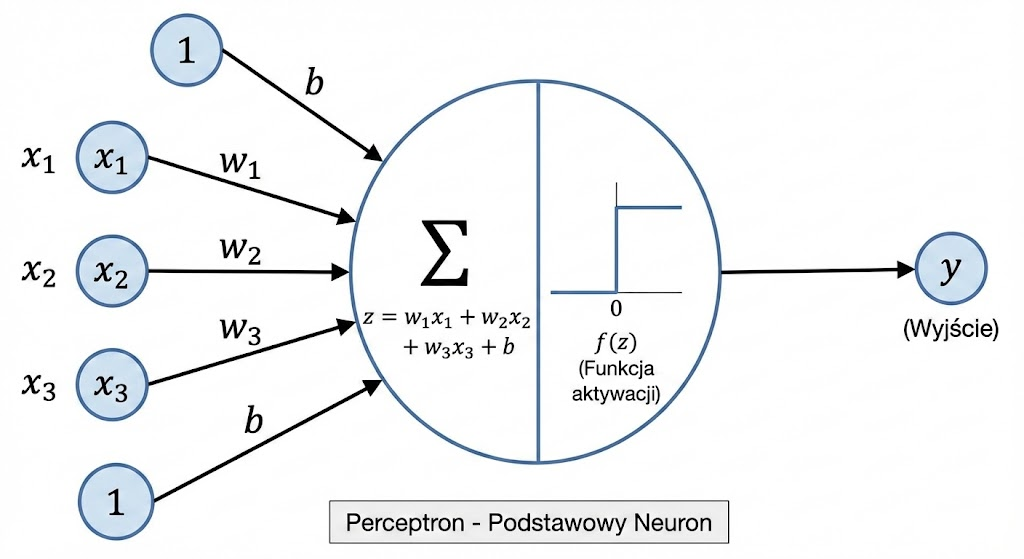